In [28]:
#Import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
palette = sns.color_palette('Set2')
import datetime as dt
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from sklearn.preprocessing import OneHotEncoder
from sklearn import neighbors
from sklearn import model_selection, preprocessing
import xgboost as xgb

In [2]:
def trans_datetime_features(df):
    df["year"] = df["transactiondate"].dt.year
    df["quarter"] = (df["transactiondate"].dt.year - 2016)*4 +df["transactiondate"].dt.quarter
    df["month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month
    df["day"] = df["transactiondate"].dt.day
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

In [3]:
'''
stackoverflow_Aran: a function to to find the most correlated pairs and avoid duplicate and self correlations with proper sorting
'''
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


# Load the data

In [4]:
#load the properties data
properties2016 = pd.read_csv('properties_2016.csv', low_memory = False)
properties2017 = pd.read_csv('properties_2017.csv', low_memory = False)
#load the train data
train2016 = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)
train2017 = pd.read_csv('train_2017.csv', parse_dates=['transactiondate'], low_memory=False)

In [5]:
train2016 = trans_datetime_features(train2016)
train2017 = trans_datetime_features(train2017)
#merge the properties and train data 
train2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')
train2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')
#tax feature in 2017, np.nan
train2017.iloc[:, train2017.columns.str.startswith('tax')] = np.nan
#concat Train 2016, 2017
train_df = pd.concat([train2016, train2017], axis = 0)

In [5]:
print("Number of properties: {}".format(train_df.parcelid.nunique()))
print("Number of features: {}".format(len(train_df.columns)-1))

Number of properties: 165210
Number of features: 62


In [6]:
print("train shape: {}".format(train_df.shape))

train shape: (167888, 63)


# check on the missing data and data type

In [7]:
missing = pd.concat([train_df.isnull().sum(), 100 * train_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending = False)

,count,%
buildingclasstypeid,167857,99.98154
finishedsquarefeet13,167813,99.95533
storytypeid,167795,99.94461
basementsqft,167795,99.94461
yardbuildingsqft26,167723,99.90172
...,...,...
day,0,0.00000
month,0,0.00000
quarter,0,0.00000
year,0,0.00000


# Exclue Missing data > 98%

In [8]:
# find the columns with the missing values, and set the threshhold 98
missing = pd.concat([train_df.isnull().sum(), 100 * train_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
remove_missing_cols = missing[missing.iloc[:,1] > 98].index.tolist()
print("Remove containing missing values 98 percent of cols: %s" % len(remove_missing_cols))
print('Remove_missing_cols are: \n %s' % remove_missing_cols)

Remove containing missing values 98 percent of cols: 15
Remove_missing_cols are: 
 ['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedsquarefeet13', 'finishedsquarefeet6', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'storytypeid', 'typeconstructiontypeid', 'yardbuildingsqft26', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']


# Exclude unique values and seperate them by dtypes

In [9]:
exclude_unique = []
binary_list = []
for c in train_df.columns:
    num_uniques = len(train_df[c].unique())
    if train_df[c].isnull().sum() != 0:
        num_uniques -= 1
    if num_uniques == 1 \
    and (train_df[c].dtype == np.float64 or train_df[c].dtype == np.int64):
        exclude_unique.append(c)
    if num_uniques == 1 \
    and (train_df[c].dtype == object):
        binary_list.append(c)
print(exclude_unique)
print(binary_list)

['decktypeid', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'storytypeid']
['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']


# trainig_features_so far

In [10]:
exclude_list = ['parcelid', 'logerror']
exclude_list = exclude_list + remove_missing_cols + exclude_unique
train_features = [e for e in train_df.columns if e not in exclude_list]
print("We are training features so far: %s" % len(train_features))
print('Training features are: \n %s ' % train_features)

We are training features so far: 44
Training features are: 
 ['year', 'quarter', 'month', 'day', 'airconditioningtypeid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet15', 'finishedsquarefeet50', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock'] 


# define categorical features that have unique counts less than 1000, and dont meeting conditions that are numeric values

In [11]:
feature_nunique = pd.DataFrame(train_df[train_features].nunique(), columns=['count'])
cat_possible_list = feature_nunique[feature_nunique['count'] < 1000].index.tolist()
cat_feature_list = [f for f in cat_possible_list if 'sqft' not in f and 'cnt' not in f and 'nbr' not in f and 'number' not in f]
cat_features = [train_df[train_features].columns.get_loc(col) for col in cat_feature_list]
print ("Number of categorical features are defined while they have less than 1000 unique values and \n have no numeric types of features in the list: %s" % len(cat_feature_list))
print('\n', '************************************************************************************************************')
print ("Categorical features are defined while they have less than 1000 unique values and \n have no numeric types of features in the list: \n %s" % cat_feature_list)

Number of categorical features are defined while they have less than 1000 unique values and 
 have no numeric types of features in the list: 17

 ************************************************************************************************************
Categorical features are defined while they have less than 1000 unique values and 
 have no numeric types of features in the list: 
 ['year', 'quarter', 'month', 'day', 'airconditioningtypeid', 'buildingqualitytypeid', 'fips', 'hashottuborspa', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'yearbuilt', 'assessmentyear']


# target variable outlier check

In [12]:
#check summary statistics of target variables, obvious outlier
train_df['logerror'].describe(percentiles = [0.01, 0.05, 0.95, 0.99])

count   167888.00000
mean         0.01391
std          0.16571
min         -4.65542
1%          -0.33114
5%          -0.12440
50%          0.00600
95%          0.17125
99%          0.49590
max          5.26300
Name: logerror, dtype: float64

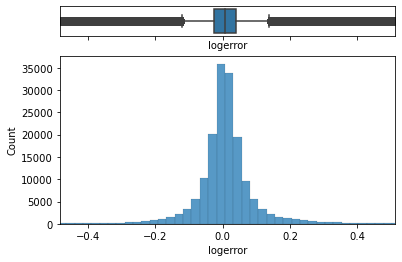

In [13]:
# distribution of logerror with mean+-3std
x = train_df['logerror']; st = train_df['logerror'].std()
mean = np.mean(train_df['logerror'])
figure, (ax_box, ax_hist) = plt.subplots(2, sharex=True ,
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x = x, ax=ax_box)
sns.histplot(x = x, ax=ax_hist, bins=400, kde=False)
ax_box.set(yticks=[])
plt.xlim([mean-3*st, mean+3*st])
plt.show()

In [14]:
#remove outliers of logerror regarding Z-score
train_df = train_df[(np.abs(stats.zscore(train_df["logerror"])) < 3)]

# feature statistics

In [15]:
train_df[train_features].describe()

,year,quarter,month,day,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet15,finishedsquarefeet50,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
count,165420.00000,165420.00000,165420.00000,165420.00000,53252.00000,165390.00000,165390.00000,105484.00000,163707.00000,12767.00000,164584.00000,157411.00000,6334.00000,12767.00000,165390.00000,17726.00000,163707.00000,54894.00000,54894.00000,104156.00000,165390.00000,165390.00000,147180.00000,165390.00000,165390.00000,162153.00000,165390.00000,65867.00000,165312.00000,165390.00000,21917.00000,107281.00000,4988.00000,164428.00000,37698.00000,164929.00000,89015.00000,165390.00000,165388.00000,89010.00000,164576.00000
mean,2016.46188,4.00897,11.02952,16.42330,1.81563,2.28962,3.04260,6.01450,2.31272,1355.40691,1776.54875,1751.25749,2356.65993,1365.94494,6048.88489,1.18882,2.24518,1.81320,347.11854,3.91326,34006690.65625,-118200675.57430,29418.73428,261.86074,60491943.32632,33753.59977,2527.80353,189343.24972,96584.60892,1.48250,1.00890,1.10791,307.60946,1968.74552,1.43880,183983.36821,456829.35044,2015.46178,287352.07428,5968.45318,60494334914789.99219
std,0.49855,2.05263,6.16726,8.98409,2.97260,0.99416,1.14255,1.88343,0.97204,655.20753,932.02274,914.39557,1100.40626,692.83920,20.72825,0.48591,0.95902,0.59612,264.02117,3.63955,265275.10778,360445.67371,120936.56634,4.94048,205701.44411,46917.76854,804.35442,165896.13649,3598.94708,2.82546,0.10835,0.99206,227.38883,23.69514,0.54447,215633.73593,550305.40192,0.49854,436827.73253,6776.04441,1061632795052.23621
min,2016.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,44.00000,2.00000,2.00000,560.00000,44.00000,6037.00000,1.00000,1.00000,0.00000,0.00000,1.00000,33339295.00000,-119475416.00000,167.00000,31.00000,60371011.10100,3491.00000,1286.00000,6952.00000,95982.00000,0.00000,1.00000,1.00000,11.00000,1824.00000,1.00000,44.00000,22.00000,2015.00000,22.00000,49.08000,60371011101000.00000
25%,2016.00000,2.00000,6.00000,9.00000,1.00000,2.00000,2.00000,4.00000,2.00000,945.00000,1184.00000,1173.00000,1633.25000,945.50000,6037.00000,1.00000,2.00000,2.00000,0.00000,2.00000,33812430.00000,-118413499.50000,5705.00000,261.00000,60373201.00300,12447.00000,1286.00000,46736.00000,96193.00000,0.00000,1.00000,1.00000,175.00000,1953.00000,1.00000,82962.00000,200156.00000,2015.00000,84205.50000,2884.96000,60373201002001.75000
50%,2016.00000,4.00000,10.00000,16.00000,1.00000,2.00000,3.00000,7.00000,2.00000,1252.00000,1541.00000,1521.00000,2091.00000,1252.00000,6037.00000,1.00000,2.00000,2.00000,434.00000,2.00000,34021500.00000,-118175716.50000,7200.00000,261.00000,60376040.02101,25218.00000,3101.00000,118872.00000,96393.00000,0.00000,1.00000,1.00000,252.00000,1970.00000,1.00000,134406.00000,343660.00000,2015.00000,198160.50000,4551.02500,60376040011017.50000
75%,2017.00000,6.00000,17.00000,24.00000,1.00000,3.00000,4.00000,7.00000,3.00000,1615.00000,2100.00000,2064.00000,2828.25000,1618.50000,6059.00000,1.00000,3.00000,2.00000,488.00000,7.00000,34173781.75000,-117923629.25000,11727.00000,266.00000,60590423.30100,45457.00000,3101.00000,274800.00000,96987.00000,0.00000,1.00000,1.00000,375.00000,1987.00000,2.00000,214294.00000,540589.00000,2016.00000,355000.00000,6897.41250,60590423293001.00000
max,2017.00000,7.00000,21.00000,31.00000,13.00000,20.00000,16.00000,12.00000,20.00000,6912.00000,35640.00000,21929.00000,35640.00000,12467.00000,6111.00000,5.00000,20.00000,24.00000,7339.00000,24.00000,34818767.00000,-117554636.00000,6971010.00000,275.00000,611

In [16]:
# fix some obvious outliers
train_df = train_df[train_df['calculatedfinishedsquarefeet'] !=2]

# Feature correlation and importance

In [17]:
num_list = list(set(train_features) - set(cat_feature_list))
cols = [col for col in num_list if train_df[col].dtype=='float64']

Text(0.5, 1.0, 'Feature correlation map')

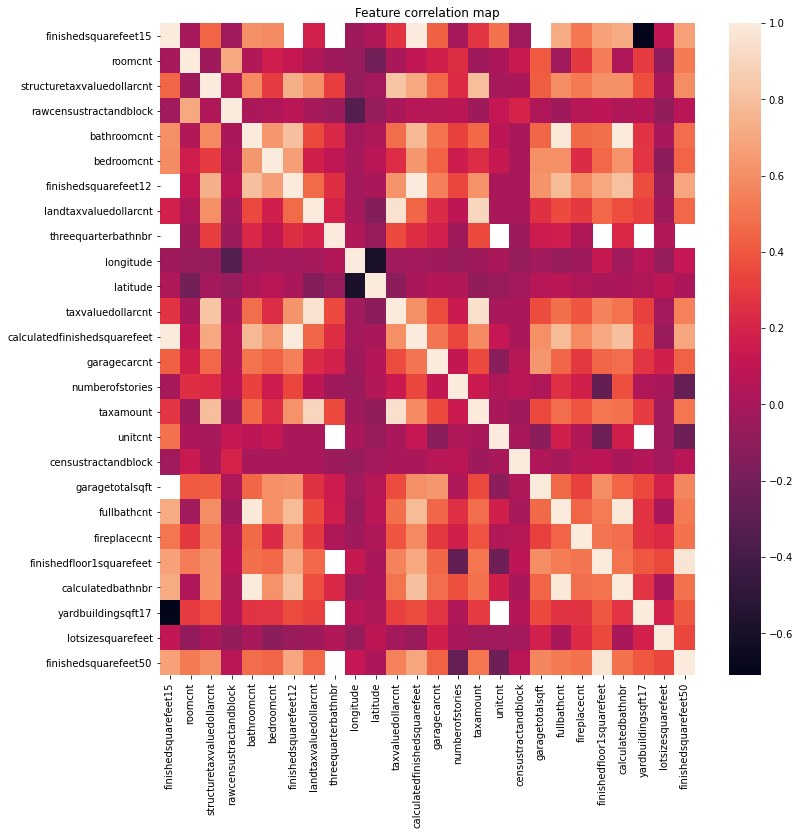

In [18]:
plt.figure(figsize = (12,12))
sns.heatmap(train_df[cols].corr())
plt.title('Feature correlation map')

In [21]:
top_corr = get_top_abs_correlations(train_df[cols], 10)
top_corr = top_corr[top_corr >= 0.9].dropna()
top_corr

finishedsquarefeet15      calculatedfinishedsquarefeet   1.00000
bathroomcnt               calculatedbathnbr              1.00000
finishedsquarefeet12      calculatedfinishedsquarefeet   1.00000
fullbathcnt               calculatedbathnbr              0.98405
bathroomcnt               fullbathcnt                    0.98405
finishedfloor1squarefeet  finishedsquarefeet50           0.96973
landtaxvaluedollarcnt     taxvaluedollarcnt              0.95519
taxvaluedollarcnt         taxamount                      0.94945
landtaxvaluedollarcnt     taxamount                      0.90234
dtype: float64

In [29]:
# xgboost for feature selection

train_X = train_df[train_features]
train_y = train_df.logerror.values

for c in train_X.columns:
    if train_X[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_X[c].values))
        train_X[c] = lbl.transform(list(train_X[c].values))

xgb_params = {
    'eta': 0.001,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed' : 0
}

dtrain = xgb.DMatrix(train_X, train_y, feature_names = train_X.columns.values)
model = xgb.train(dict(xgb_params), dtrain, num_boost_round=150)

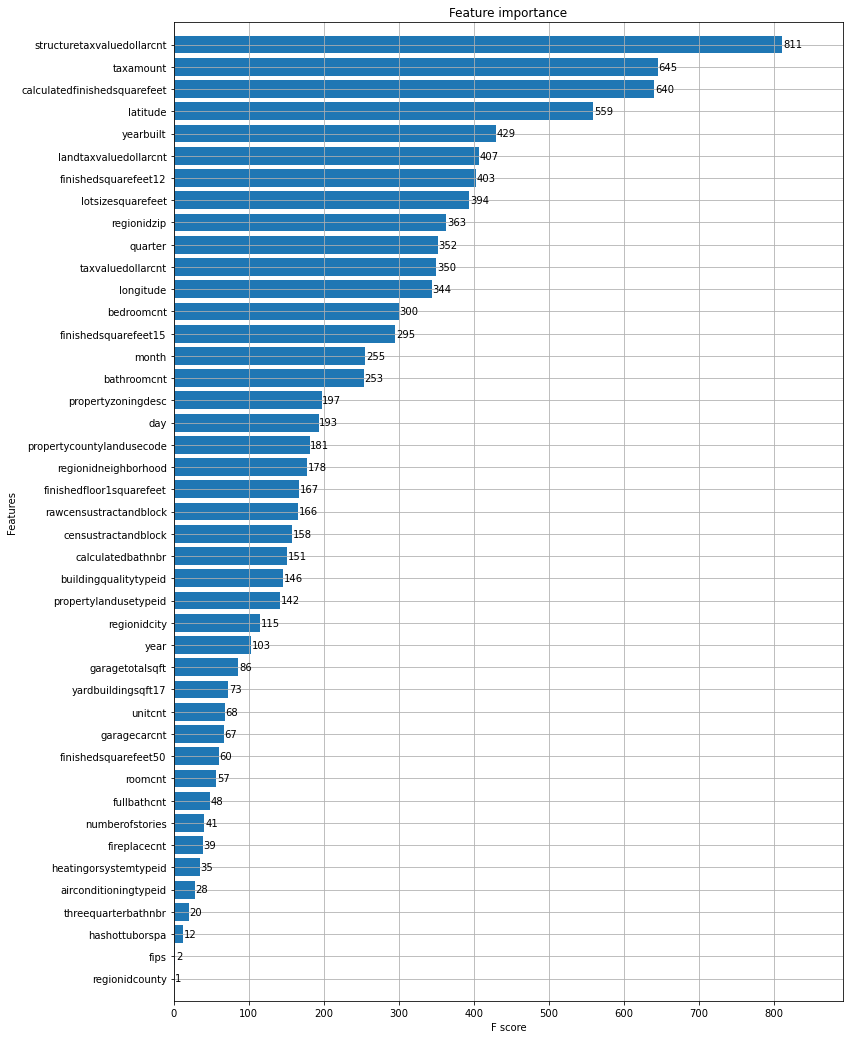

In [30]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()